# 1 Nearest Neighbor Classification on Real Data

## 1.1  Exploring the Data

> Load the dataset from sklearn and extract the data:

In [100]:
from sklearn.datasets import load_digits

digits = load_digits()  # load the dataset

print(digits.keys())
# extract all interesting data
data = digits.data
images = digits.images
target = digits.target
target_names = digits.target_names

print(data.dtype)


dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])
float64


-----------

> What is the size of these images (the numpy attribute shape might come in handy)?

In [101]:
images.shape

(1797, 8, 8)

Each image is 8 by 8 pixels, there are a total of 1797 images.

----------------


> Visualize one image of a 3 using the ``imshow`` function ``from matplotlib.pyplot``, trying the two interpolation methods in the code:

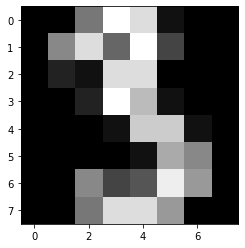

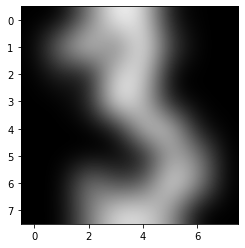

In [102]:
import numpy as np
import matplotlib.pyplot as plt


img = images[np.where(target==3)[0][0]]

assert 2 == len(img.shape)

for _interpolation in ("nearest", "bicubic"):
    plt.figure()
    plt.gray()
    plt.imshow(img, interpolation=_interpolation)
    plt.show()


-----------------------------------------


> Moreover, sklearn provides a convenient function to separate the data into a training and a test set.

In [103]:
from sklearn import model_selection

X_all = data
y_all = target

X_train, X_test, y_train, y_test = model_selection.train_test_split(data,
                                                                    target,
                                                                    test_size=0.4,
                                                                    random_state=0
                                                                    )

## 1.2 Distance function computation using loops


In [104]:
from itertools import product

def dist_loop(training: np.ndarray, test: np.ndarray):
    """Calculate the euclidean distance between all instances in the training and test set

    Using a for loop
    
    Parameters
    ----------
    training : numpy.ndarray
        2D array of the size N x D, with D pixels per image and N instances
        in the training set.

    test : np.ndarray
        2D array of the size M x D, with D pixels per image and M instances 
        in the test set.

    Returns
    -------
    distances : np.ndarray
        2D array of the size N x M. 
        The euclidean distance between all instances.

    """
    N, D = training.shape
    M, _ = test.shape
    
    distances: np.ndarray = np.empty(N*M)

    for i, (n, m) in enumerate(product(training, test)):
        distances[i] = np.linalg.norm(m - n)

    return distances.reshape((N, M))


## 1.3 Distance function computation using vectorization

In [105]:
def dist_vec(training: np.ndarray, test: np.ndarray):
    """Calculate the euclidean distance between all instances in the training and test set

    Using numpy vectorized functions
    
    Parameters
    ----------
    training : numpy.ndarray
        2D array of the size N x D, with D pixels per image and N instances
        in the training set.

    test : np.ndarray
        2D array of the size M x D, with D pixels per image and M instances 
        in the test set.

    Returns
    -------
    distances : np.ndarray
        2D array of the size N x M. 
        The euclidean distance between all instances.

    """

    N, D = training.shape
    M, _ = test.shape
    
    
    return np.linalg.norm(training[:, None] - test[None, :], axis=-1).reshape((N, M))


-------------------------------

> Verify that the new function returns the same distances as the loop-based version.

In [106]:
np.testing.assert_allclose(dist_loop(X_train, X_test), dist_vec(X_train, X_test))
print("Assertion passed successfully!")

Assertion passed successfully!


------------------------------

> Now compare the run times of the two implementations using jupyter’s ``%timeit`` command (the vectorized version should be significantly faster)

In [107]:
print("dist_loop: ", end="")
%timeit -r3 -n3 dist_loop(X_train, X_test)
print("dist_vec: ", end="")
%timeit -r3 -n3 dist_vec(X_train, X_test)


dist_loop: 2.01 s ± 16.4 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)
dist_vec: 594 ms ± 7.58 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


-------------------------


## 1.4 Implement the k-nearest neighbor classifier

Error rate for k=1: 1.3888888888888888%
Error rate for k=3: 0.6944444444444444%
Error rate for k=5: 0.6944444444444444%
Error rate for k=9: 0.6944444444444444%
Error rate for k=17: 0.6944444444444444%
Error rate for k=33: 2.083333333333333%


Text(0, 0.5, 'Error Rate [%]')

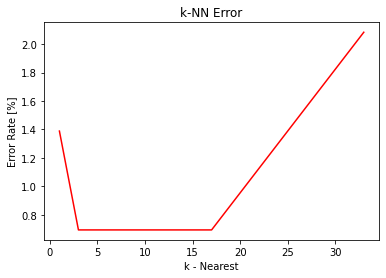

In [108]:

y_train_mask = np.where((y_train==3) | (y_train==9))
y_train_3_9 = y_train[y_train_mask]
x_train_3_9 = X_train[y_train_mask]

y_test_mask = np.where((y_test==3) | (y_test==9))
y_test_3_9 = y_test[y_test_mask]
x_test_3_9 = X_test[y_test_mask]





def nearest_neighbor(train_y, train_x, test_x, k=1):
    # get all distances
    distances = dist_vec(train_x, test_x).T
    """
    axis=0
      |
      v
    0 1 2 
    3 4 5 <- axis=1
    6 7 8 
    """
    k_nearest_mask = np.argpartition(distances, k, axis=1)[:, :k]
    _y_nearest = train_y[k_nearest_mask]

    u, indices = np.unique(_y_nearest, return_inverse=True)
    test_y_hat = u[
        np.argmax(
            np.apply_along_axis(
                np.bincount,
                axis=1,
                arr=indices.reshape(_y_nearest.shape),
                minlength=np.max(indices) + 1
            ),
            axis=1
        )
    ]

    return test_y_hat


errors = []
ks = [1, 3, 5, 9, 17, 33]
for n in ks:
    y_hat = nearest_neighbor(y_train_3_9, x_train_3_9, x_test_3_9, k=n)
    err = (np.sum(y_hat!=y_test_3_9)/y_test_3_9.shape[0])*100
    print(f"Error rate for k={n}: {err}%")
    errors.append(err)


plt.plot(ks, errors, color="red", )
plt.title("k-NN Error")
plt.xlabel("k - Nearest")
plt.ylabel("Error Rate [%]")



> Describe the dependency of the classification performance on *k*.    
  
The Error rate is lowest between 3 and 17 for this specific dataset.  
Higher *k*s probably have a higher chance of including wrong labels in the neighborhood.

# 2 Cross-validation

In [109]:
import sklearn.neighbors as skn


def split_folds(data, target, L: int):
    permutation = np.random.permutation(target.size)
    data = data[permutation]
    target = target[permutation]

    data = np.array_split(data, L)
    target = np.array_split(target, L)

    return data, target


Ls = [2, 5, 10]
ks = [1, 12]

for l in Ls:
    X_folds, y_folds = split_folds(data, target, l)
    for k in ks:
        average_error_for_l = []
        sk_average_error_for_l = []
        for i in range(l):
            x_test = X_folds[i]
            y_test = y_folds[i]

            x_train = np.concatenate(
                [x for j, x in enumerate(X_folds) if j != i])
            y_train = np.concatenate(
                [y for j, y in enumerate(y_folds) if j != i])

            y_predict = nearest_neighbor(y_train, x_train, x_test, k=k)
            average_error_for_l.append(
                (np.sum(y_predict != y_test)/y_test.shape[0])*100)

            sk_neighbor = skn.KNeighborsClassifier(n_neighbors=k)
            sk_neighbor.fit(x_train, y_train)
            sk_y_predict = sk_neighbor.predict(x_test)
            sk_average_error_for_l.append(
                (np.sum(sk_y_predict != y_test)/y_test.shape[0])*100)

        print(
f"""
{'_'*50}
|{f'Given k={k}, L={l}':^48}|
|{f'Mean Error':>23} | {f'Standard Deviation':^22}|
|{f'Our NN: {np.mean(average_error_for_l):9.3f}%':>23} | {f'{np.std(average_error_for_l):17.3f}%':^22}|
|{f'SK  NN: {np.mean(sk_average_error_for_l):9.3f}%':>23} | {f'{np.std(sk_average_error_for_l):17.3f}%':^22}|
|{'_'*48}|"""
              )

        



__________________________________________________
|                 Given k=1, L=2                 |
|             Mean Error |   Standard Deviation  |
|     Our NN:     1.614% |               0.500%  |
|     SK  NN:     1.614% |               0.500%  |
|________________________________________________|

__________________________________________________
|                 Given k=5, L=2                 |
|             Mean Error |   Standard Deviation  |
|     Our NN:     2.226% |               0.221%  |
|     SK  NN:     2.226% |               0.221%  |
|________________________________________________|

__________________________________________________
|                Given k=10, L=2                 |
|             Mean Error |   Standard Deviation  |
|     Our NN:     2.671% |               0.110%  |
|     SK  NN:     2.671% |               0.110%  |
|________________________________________________|

__________________________________________________
|                Given k=33

As one can see, with increasing *L* the ``Mean Error`` goes down. But the ``Standard Deviation`` increases.  
Furthermore, both of the algortihms seem to have the same performance.